In [1]:
import scanpy as sc
import anndata
#import pl
#import tl
import numpy as np
import time as time

# Load Dataset
print("Loading dataset")
filelocation = r"datasets/VBh_converted.h5ad"
#filelocation = "C:/Users/xilef/Desktop/Helmholtz/CantoUnstained_converted.h5ad"
adata = anndata.read_h5ad(filelocation)
print(f"dataset with {len(adata)} cells loaded")

# subsampling (for slow/low memory computers)
#sc.pp.subsample(adata, 0.8)

# removing some channels
for channel in adata.var_names:
    if channel.endswith("-H") or channel == "Time" or channel == "FSC-Width":
        adata.obs[channel]=adata.X[:,adata.var_names == channel]
        adata = adata[:,adata.var_names != channel]

# normalizing
print("Normalizing")
adata.X = np.arcsinh(adata.X / 10)

# calc knn
print("Calculating connectivities")
sc.pp.neighbors(adata, n_neighbors=20)

# calculating louvain clustering of original dataset
print("Calculating louvain clustering")
sc.tl.louvain(adata, resolution=0.5, key_added="louv_05")

print("Done!")

Loading dataset


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


dataset with 129467 cells loaded
Normalizing
Calculating connectivities
Calculating louvain clustering
Done!


**HUMAP function**

In [2]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs

import matplotlib.pyplot as plt

def _humap(adata, n_scales: int = 1, copy: bool = False, verbose: bool = False):
    
    # check if knn graph has been calculated beforehand
    assert 'connectivities' in adata.obsp.keys(), "No knn graph found. Calculate with scanpy.tl.neighbors(...)"
    
    # create list with copy of adata as first element
    scales = list()
    scales.append(adata.copy())
    
    for s in range(n_scales):
        if verbose: print(f"-----\nCalculating scale {s}")
        ### getting landmarks
        
        # copy last scale
        speichi = scales[-1].copy()
        
        #sc.pp.neighbors(speichi)
        c = speichi.obsp['connectivities']
        T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))
        D, V = eigs(T.T, which='LM')

        # landmark probabilities
        pi = V[:, 0]
        pi = pi.real
        pi /= pi.sum()

        ### finding inflection point
        inflectionPoint = findInflectionPointFlattestPartSlidingWindow(pi[pi.argsort()][::-1])
        if verbose: print(f"Found inflection point at {inflectionPoint}")
        
        ### subsample data
        
        # indices of landmarks sorted by probability
        lm_ind = pi.argsort()
        
        speichi = speichi[lm_ind[:inflectionPoint]]

        if verbose: print(f"Calculating scale {s} with {speichi.n_obs} cells")
        
        # plotting
        if verbose:
            plt.plot(pi[pi.argsort()][::-1])
            plt.vlines(inflectionPoint, ymin=0, ymax=max(pi))
            plt.show()
        
        # (re)calculate knn
        sc.pp.neighbors(speichi, n_neighbors=20) # TODO remove magic number
        # calculate umap embedding
        sc.tl.umap(speichi)
        scales.append(speichi)
        
    # removing first element as it is a copy of adata
    scales.pop(0)
    
    # add list of scales to .uns
    adata.uns['HUMAP_scales'] = scales
    return adata if copy else None
    


In [3]:
from scipy.signal import medfilt
from kneed import KneeLocator


def findElbowInflectionMedian(valArray):
    infPoint = 0
    
    y = valArray
    dy = np.diff(y, n=1)
    
    if len(dy)%2 > 0:
        dy = dy[:-1]
    
    dy = medfilt(dy)
    
    print("Plotting derivative")
    plt.plot(dy)
    plt.show()
    
    # TODO why always different results?
    # TODO why not smooth? --> y is descending
    
    #infPoint = np.argmax(dy==0)
    infPoint = np.argmax(dy==max(dy))
    print(max(dy))
    
    #plt.plot(dy[:int(len(dy)/20)])
    #plt.show()
    
    ## version: CUMSUM --> cut where cumsum > 10%
    # speichi = 0
    # for i in range(len(valArray)):
    #     speichi += valArray[i]
    #     if speichi > 0.1:
    #         infPoint = i
    #         break
    
    return infPoint


def findKneeInflection(valArray):
    kn = KneeLocator(range(len(valArray)), valArray, curve='convex', direction='decreasing')
    return kn.elbow

from numba import jit

@jit
def findInflectionPointFlattestPartSlidingWindow(valArray):
    windowSize = (int) (len(valArray)*0.1)
    windowErg = list()
    for step in range(len(valArray)-windowSize):   
        windowErg.append(np.sum(np.abs(valArray[step:step+windowSize]-np.mean(valArray[step:step+windowSize]))))
    
    return np.argmax(windowErg == min(windowErg))

-----
Calculating scale 0


<ipython-input-3-92a31f45528d>:47: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "findInflectionPointFlattestPartSlidingWindow" failed type inference due to: No implementation of function Function(<built-in function eq>) found for signature:
 
 >>> eq(list(float32)<iv=None>, float32)
 
There are 30 candidate implementations:
   - Of which 28 did not match due to:
   Overload of function 'eq': File: <numerous>: Line N/A.
     With argument(s): '(list(float32)<iv=None>, float32)':
    No match.
   - Of which 2 did not match due to:
   Operator Overload in function 'eq': File: unknown: Line unknown.
     With argument(s): '(list(float32)<iv=None>, float32)':
    No match for registered cases:
     * (bool, bool) -> bool
     * (int8, int8) -> bool
     * (int16, int16) -> bool
     * (int32, int32) -> bool
     * (int64, int64) -> bool
     * (uint8, uint8) -> bool
     * (uint16, uint16) -> bool
     * (uint32, uint32) -> bool
     * 

Found inflection point at 57581
Calculating scale 0 with 57581 cells


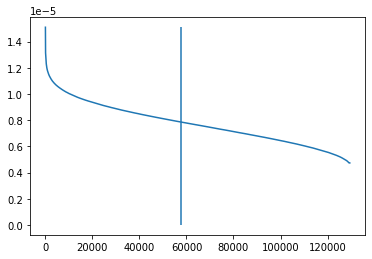

-----
Calculating scale 1
Found inflection point at 24035
Calculating scale 1 with 24035 cells


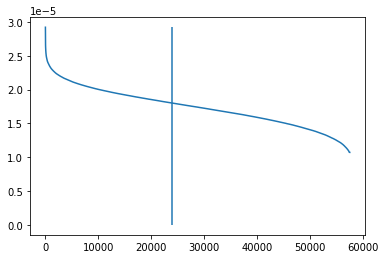

-----
Calculating scale 2
Found inflection point at 9250
Calculating scale 2 with 9250 cells


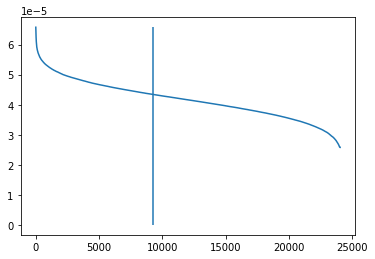

-----
Calculating scale 3
Found inflection point at 4342
Calculating scale 3 with 4342 cells


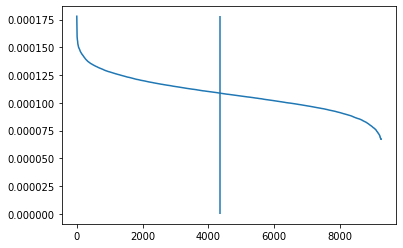

In [4]:
_humap(adata, n_scales = 4, verbose=True)

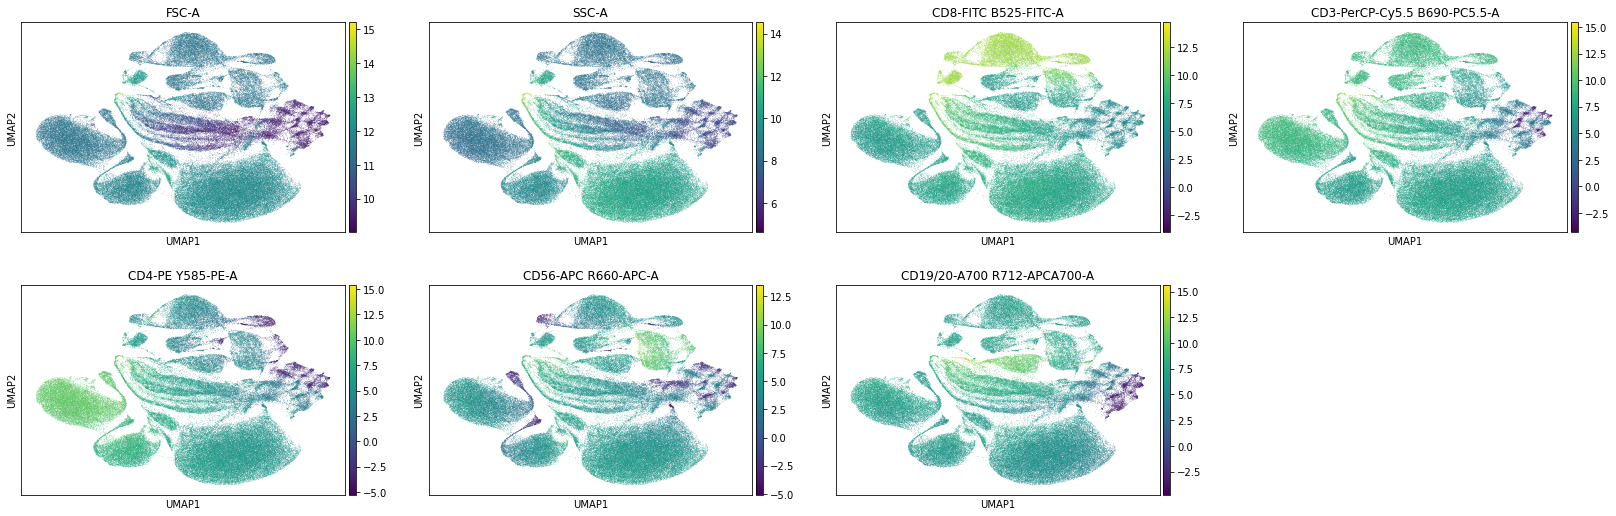

Scale 0 with 57581 cells


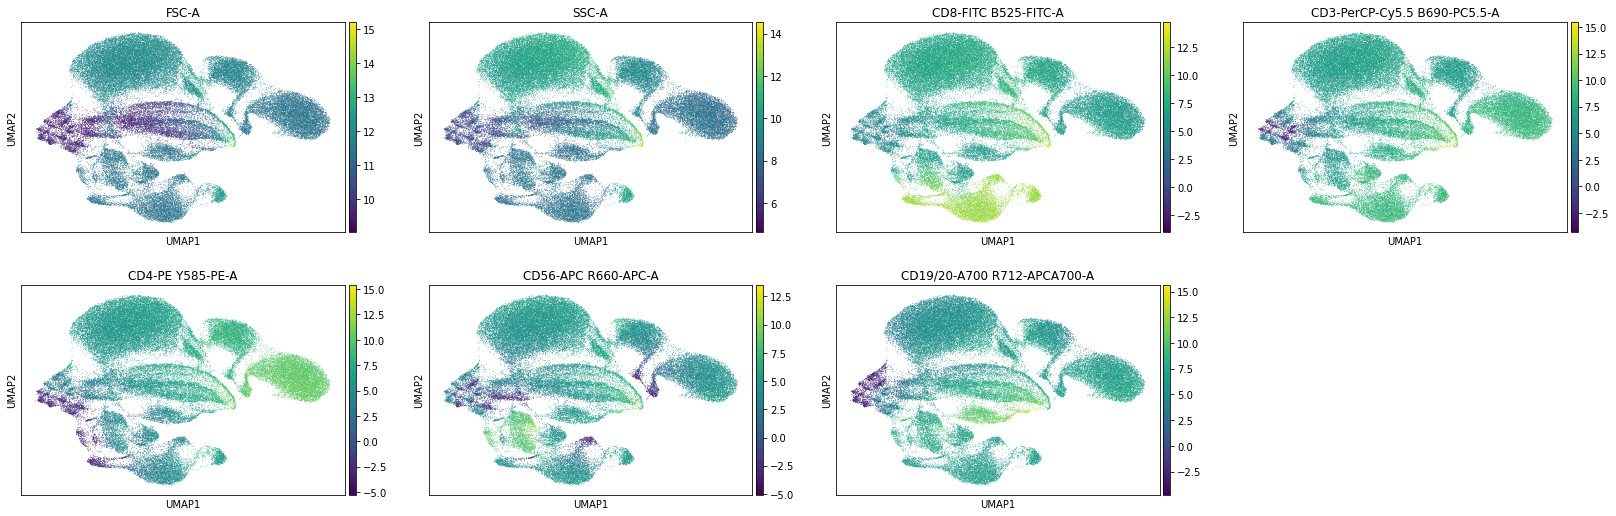

Scale 1 with 24035 cells


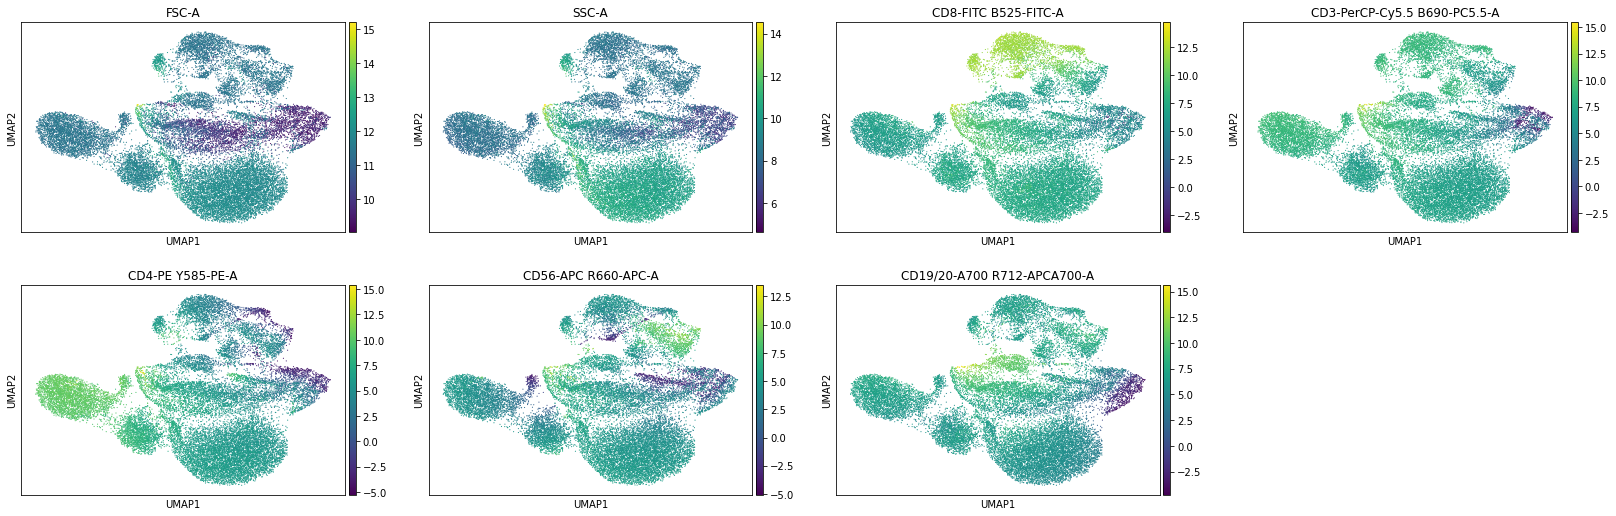

Scale 2 with 9250 cells


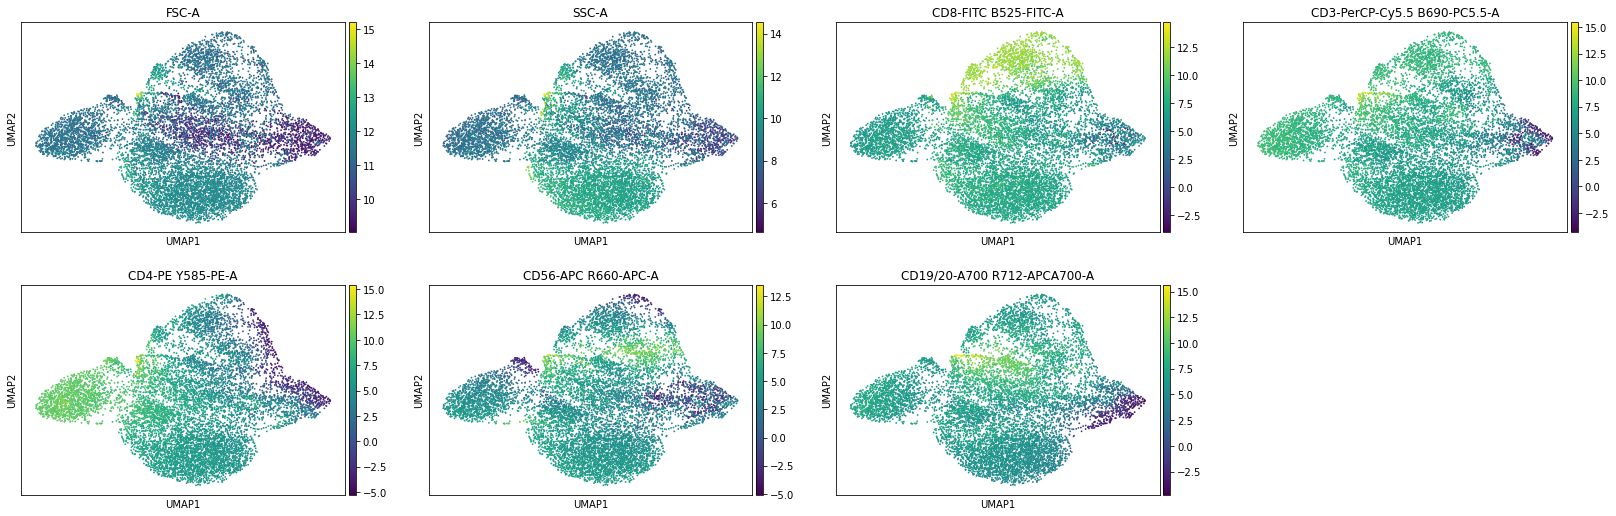

Scale 3 with 4342 cells


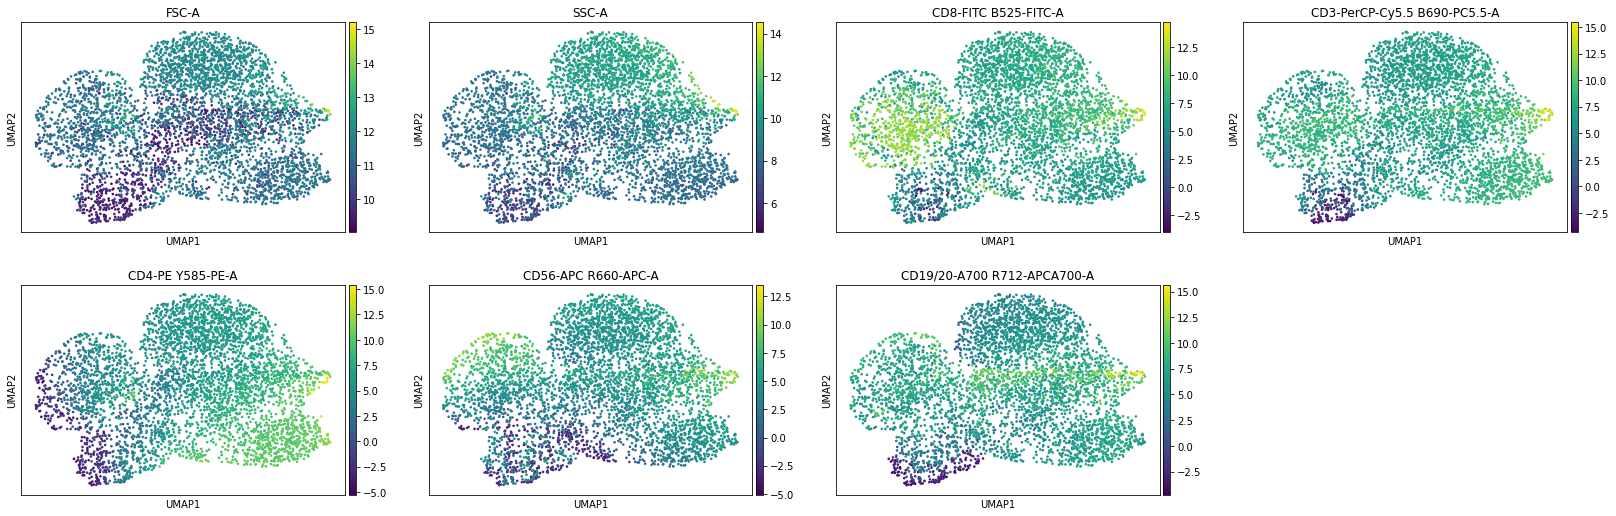

In [5]:
if 'umap' not in adata.obsm:
    sc.tl.umap(adata)
sc.pl.umap(adata, color=adata.var_names.values)
for s in enumerate(adata.uns['HUMAP_scales']):
    print(f"Scale {s[0]} with {np.shape(s[1].X)[0]} cells")
    sc.pl.umap(s[1], color=adata.var_names.values)  #[0]


**Cluster**

Louvain with resolution 0.5


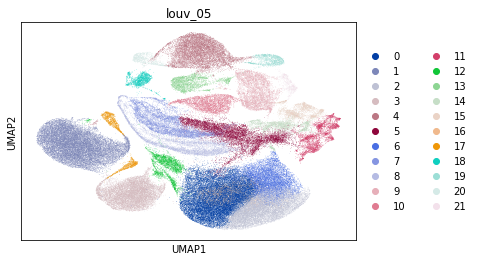

Scale 0


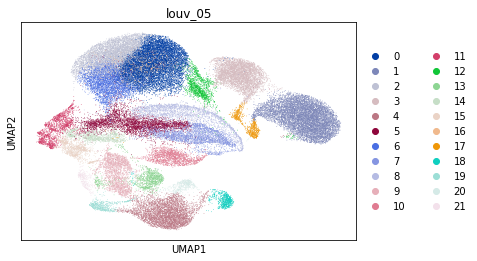

Scale 1


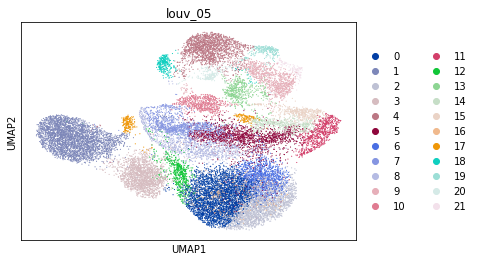

Scale 2


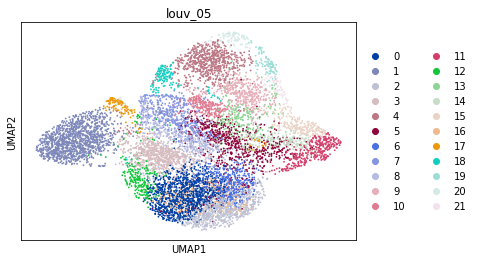

Scale 3


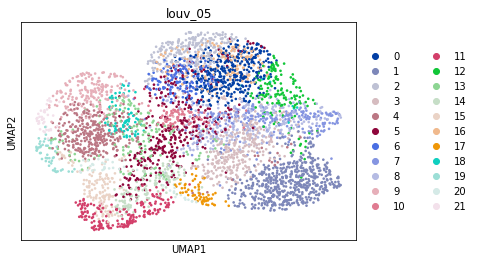

In [6]:
print("Louvain with resolution 0.5")
sc.pl.umap(adata, color="louv_05")
for s in enumerate(adata.uns['HUMAP_scales']):
    print(f"Scale {s[0]}")
    sc.pl.umap(s[1], color="louv_05")
    


**Calculate Landmarks**

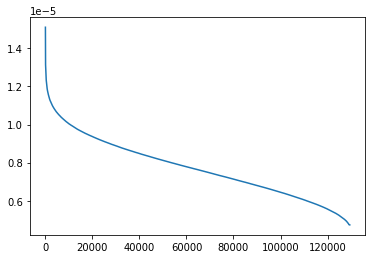

In [7]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs
# concentrated

c = adata.obsp['connectivities']

T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))

D, V = eigs(T.T, which='LM')

pi = V[:, 0]

pi = pi.real

pi /= pi.sum()

Pi = spdiags(pi, 0, pi.shape[0], pi.shape[0])

plt.plot(pi[pi.argsort()][::-1])
plt.show()
